# Testing the Relational Graphlet Convolution Module on SET

In [11]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# import wandb

import tensorflow as tf

from tqdm.auto import tqdm, trange

# %load_ext autoreload
# %autoreload 2
# from relational_neural_networks.relational_neural_networks import *
import sys; sys.path.append('../..')
import set_game
from relational_neural_networks import utils

## Generate dataset for SET

In [12]:
X, y = set_game.create_Xy_data(encode=True)
class_names = ['non-set', 'set']

In [13]:
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_res = np.array(X)[np.squeeze(res_idx)]

In [14]:
num_extra_attrs = 3 # number of additional spurious attributes to add
num_vals = 3 # num of possible values per additional attribute

def generate_spurious_attr_card_suffix(num_cards, num_attrs, num_vals):

    attr_vals = np.random.randint(0, num_vals,  size=num_cards)
    additional_card_attrs = np.zeros(shape=(num_cards, num_vals))
    additional_card_attrs[np.arange(num_cards), attr_vals] = 1

    for attr in range(1, num_attrs):
        attr_i_vals = np.random.randint(0, num_vals, size=num_cards)
        attr_i_enc = np.zeros(shape=(num_cards, num_vals))
        attr_i_enc[np.arange(num_cards), attr_i_vals] = 1
        additional_card_attrs = np.concatenate([additional_card_attrs, attr_i_enc], axis=1)

    return additional_card_attrs

def generate_spurious_attr_triplet_suffix(num_triplets, num_extra_attrs, num_vals):
    return np.stack([generate_spurious_attr_card_suffix(num_triplets, num_extra_attrs, num_vals) for _ in range(3)], axis=1)

# generate 'data suffix' (additional spurious attributes for each triplet of cards)
data_suffix = generate_spurious_attr_triplet_suffix(len(X_res), num_extra_attrs, num_vals)

# append spurious attribute to X
X_res_w_spurious = np.concatenate([X_res, data_suffix], axis=-1)

In [15]:
data_suffix.shape, X_res_w_spurious.shape

((12960, 3, 9), (12960, 3, 21))

In [17]:
X_train, y_train, X_val, y_val, X_test, y_test = utils.train_val_test_split(X_res_w_spurious, y_res, test_size=0.4, val_size=0.1)

In [18]:
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

batch_size = 256
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [41]:
def sample_train_ds(X_train, y_train, sample_size, batch_size=batch_size):
    sample_idx = np.random.choice(len(y_train), size=sample_size, replace=False)
    X_train_ = X_train[sample_idx]
    y_train_ = y_train[sample_idx]
    y_train_ = tf.one_hot(y_train_, 2)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)
    return train_ds

In [42]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Modeling

In [63]:
from relational_neural_networks.multi_head_relation import *
from relational_neural_networks.relational_graphlet_convolution import *

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
create_opt = lambda: tf.keras.optimizers.Adam()
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(class_id=1, name='precision'),
        tf.keras.metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50, patience=20, verbose=1)
    ]

    return callbacks

In [68]:
mhr = MultiHeadRelation(rel_dim=4, proj_dim=4, symmetric=True)
rel_conv = RelationalGraphletConvolution(
    n_filters=4, graphlet_size=3,
    symmetric_inner_prod=True, groups_type='combinations',
    permutation_aggregator='max', name='rgc')

model = tf.keras.Sequential(
    [
        mhr,
        rel_conv,
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(2, name='output')],
    name='rel_conv_net')

model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()

Model: "rel_conv_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_relation_12 (Mul  (None, 3, 3, 4)          352       
 tiHeadRelation)                                                 
                                                                 
 rgc (RelationalGraphletConv  (None, 1, 4)             144       
 olution)                                                        
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 output (Dense)              (None, 2)                 10        
                                                                 
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


In [69]:
y_train.shape, y_test.shape

((6479,), TensorShape([5184, 2]))

In [70]:
train_ds = sample_train_ds(X_train, y_train, 1500)

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=create_callbacks())

Epoch 1/200
6/6 [==============================] - 8s 255ms/step - loss: 0.7022 - acc: 0.5506 - precision: 0.8182 - recall: 0.0192 - auc: 0.5721 - val_loss: 0.7047 - val_acc: 0.4996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4967
Epoch 2/200
6/6 [==============================] - 0s 21ms/step - loss: 0.6945 - acc: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4940 - val_loss: 0.7003 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4953
Epoch 3/200
6/6 [==============================] - 0s 23ms/step - loss: 0.6877 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5029 - val_loss: 0.6973 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4968
Epoch 4/200
6/6 [==============================] - 0s 22ms/step - loss: 0.6828 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5029 - val_loss: 0.6951 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_reca

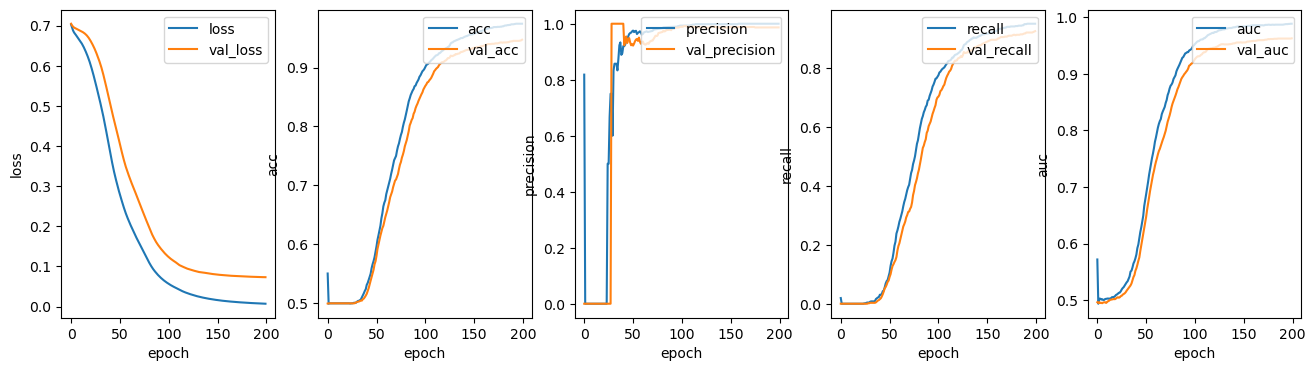

In [71]:
utils.plot_history(history, plot_attrs=('loss', 'acc', 'precision', 'recall', 'auc'), figsize=(16, 4));

## Compare to LSTM

In [86]:

model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(2, name='output')],
    name='lstm')

model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               76800     
                                                                 
 output (Dense)              (None, 2)                 258       
                                                                 
Total params: 77,058
Trainable params: 77,058
Non-trainable params: 0
_________________________________________________________________


In [87]:
y_train.shape, y_test.shape

((6479,), TensorShape([5184, 2]))

In [88]:
train_ds = sample_train_ds(X_train, y_train, 1500)

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=create_callbacks())

Epoch 1/200
6/6 [==============================] - 10s 399ms/step - loss: 0.6960 - acc: 0.5045 - precision: 0.5023 - recall: 0.1543 - auc: 0.5119 - val_loss: 0.6967 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5131
Epoch 2/200
6/6 [==============================] - 0s 35ms/step - loss: 0.6917 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5202 - val_loss: 0.6926 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5097
Epoch 3/200
6/6 [==============================] - 0s 43ms/step - loss: 0.6891 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5381 - val_loss: 0.6936 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5050
Epoch 4/200
6/6 [==============================] - 0s 53ms/step - loss: 0.6866 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5491 - val_loss: 0.6958 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_rec

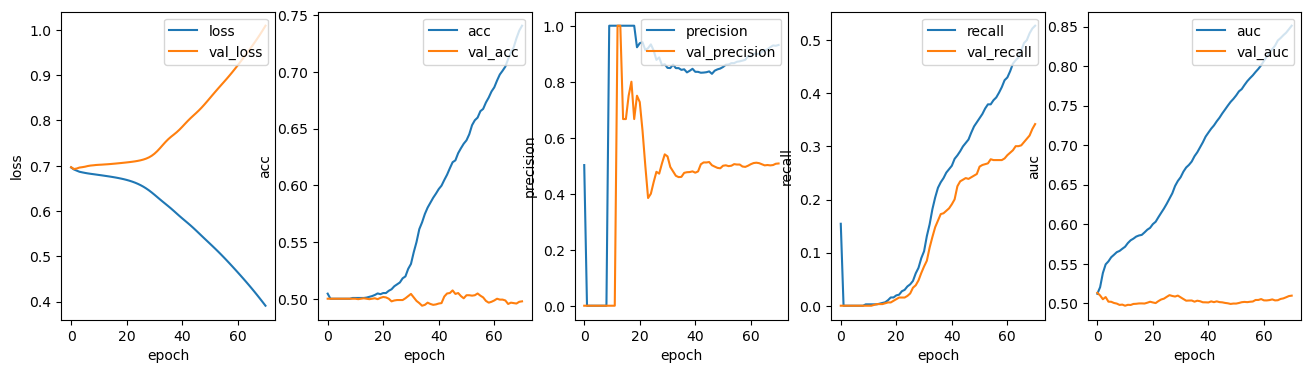

In [89]:
utils.plot_history(history, plot_attrs=('loss', 'acc', 'precision', 'recall', 'auc'), figsize=(16, 4));

## Compare to Transformer

In [81]:
# use tensorflow_models implementation
import tensorflow_models as tfm

model = tfm.nlp.models.TransformerEncoder(
    num_layers=1,
    num_attention_heads=8,
    intermediate_size=128,
    activation='relu',
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    use_bias=False,
    norm_first=True,
    norm_epsilon=1e-06,
    intermediate_dropout=0.0
)
model.build(input_shape=(None, *X_train.shape[1:])); # build model
model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
model.summary()


ModuleNotFoundError: No module named 'tensorflow_models'